In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
DTrain = pd.read_csv('BBC News Train.csv')
DTest = pd.read_csv('BBC News Test.csv')

# Exploratory Data Analysis.

In [3]:
print('Categories',DTrain.Category.unique())
DTrain.info()

Categories ['business' 'tech' 'politics' 'sport' 'entertainment']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


There are 1490 articles from 5 different categories. How are the articles divided in the five different categories.


In [4]:
DTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


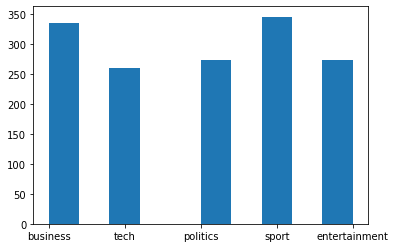

In [5]:
plt.hist(DTrain.Category);

The category labels are balanced. 

In [6]:
DTrain.head()


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


And the text is already cleaned, as it doesn't have uppercase letters or commas.

## Raw text to features vector using CountVectorizer

First we use CountVectorizer from feature extraction to find and count the 10,000 most common single words, and 2 words grams in the texts. The results go to the matrix called vectors where each column is a word or 2 word ngram and each row is a document, the number in each cell is the number of times the word appeared in that document. To extract the features I will use both the test and train data sets. 

In [7]:
DTrain['Text'].append(DTest['Text'])

0      worldcom ex-boss launches defence lawyers defe...
1      german business confidence slides german busin...
2      bbc poll indicates economic gloom citizens in ...
3      lifestyle  governs mobile choice  faster  bett...
4      enron bosses in $168m payout eighteen former e...
                             ...                        
730    eu to probe alitalia  state aid  the european ...
731    u2 to play at grammy awards show irish rock ba...
732    sport betting rules in spotlight a group of mp...
733    alfa romeos  to get gm engines  fiat is to sto...
734    citizenship event for 18s touted citizenship c...
Name: Text, Length: 2225, dtype: object

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english',ngram_range = (1,2), max_features = 10000)
vec_fit = vectorizer.fit(DTrain['Text'].append(DTest['Text'])) # (documents, vocab)
vectors = vec_fit.transform(DTrain['Text'].append(DTest['Text'])).todense()
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2225, 10000)

If we sum over the rows we get how many times each ngram appeared in total. And we can see the top 10 words and the plot of number of times each word appeared.

In [9]:
words = np.array(vec_fit.get_feature_names())
top10  = np.flip(sum(vectors).argsort()).tolist()[0][0:10]
top10
print("The top 10 words are: ", words[top10])

The top 10 words are:  ['said' 'mr' 'year' 'people' 'new' 'time' 'world' 'government' 'uk'
 'years']


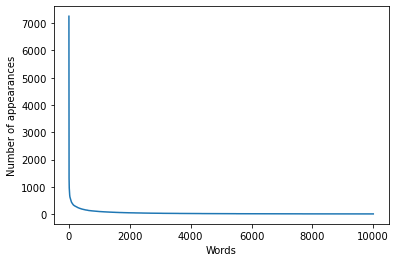

In [10]:
plt.plot(np.flip(np.sort(sum(vectors))).tolist()[0]);
plt.xlabel("Words");
plt.ylabel('Number of appearances');


The plot above is showing the total number of times the words appear, they are sorted by number of time and we can clearly see an exponential.  To take into account that some words appear a lot in all kind of documents and not just in the ones cooresponding to the category, I will use TF-IDF to vectorize the information in the texts instead of the simple bag of words counter. 

## TF-IDF for feature extraction.

To exctract the features from the texts I will use Bag of Words, TF-IDF so each text becomes a vector. This seemed as the more straight forward method to convert text to a vector from the options I found. Bag of words represent each sentence or text as all of its words in a bag without paying attention to the order or grammar in the sentence. Basically you look at each sentence and see how many times each word appears. Then a sentence like 'I love cats, because cats are the fluffiest.' Would become a vector like (1,1,2,1,1,1,1..), where the ones in the vector represent all the words that appeared only once in the sentence and the 2 is because the words cats appeared twice. While "I love cats." would be (1,1,1,0,0,0,0..) as "I", "love" and 'cats' appeared once and the rest of the word hace zeros cause they arent in the sentence. If you only do this then you have the issue that longer sentences will have bigger number and would be more important and that filler words like the, or, and will have high numbers with out giving much meaning to the sentence as they are everywhere. This two issues can be solved somehow with TF-IDF.

TF-IDF means term frequency–inverse document frequency, meaning you measure both the term frequency and the inverse document frequency. TF_IDF is calculated by ${\displaystyle \mathrm {tfidf} (t,d,D)=\mathrm {tf} (t,d)\cdot \mathrm {idf} (t,D)}$.  Where for the term frequency $\mathrm {tf} (t,d)$  you simply normalize over all the terms in the sentence. So the term frequency $\mathrm {tf} (t,d)$ , is the relative frequency of term t within document d. A way to define it is just by dividing the number of time a term t appears in a document d over the total number of words or terms in such document.  In this case each document will be the text of each article or each row of the column text

The inverse document frequency $\mathrm {idf} (t,D)$ on the other hand, looks at the whole universe of documents in the data, so in this case all the rows of the column text and is used to give weights that are inverse to the total frquency. This way filler words like "the" because they appear a lot all over the text and provide very little information about the text will be given a really small weight. To get the $\mathrm {idf} (t,D)$, you need to calculate the log of  N = the total number of documents in D, in this case is 1490 over the number of documents d or text where the term t appears. So if the word 'the' appears in every text/document then the $\mathrm {idf} (t,D) = log(1490/1490)=log(1)=0$ and the word 'the' will have a zero value in every document vector.

Sklearn has a feature extraction for text that converts a collection of raw documents to a matrix of TF-IDF features.



In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf= True,min_df =5, norm='l2', 
                        ngram_range=(1, 2),
                        max_features=10000, stop_words='english')

The vectorizer will be sublinear, meaning that the term frequency tf will be $1+log(tf)$ as the frequency of words follows an exponential law.  In min_df = 5, I specified the vectorizer to leave out words that appeared less than 5 times, norm = "l2", so the norm of a vector is given by the sum of the squares, ngram_range = (1,2), indicates that is looking for grams wit one and 2 words, so for example New York would appear as a 2 gram, max_features =10000 indicates to not extract more that 10,000 features or ngrams, and stop_words = 'english' is telling to not include commone words with no information like 'the', 'should'....


In [12]:
#Fit the vectorizer with the train data.
tfidf_vec = tfidf.fit(DTrain['Text'].append(DTest['Text']))
#labels = df.category_id

#Transform the train and test data according to the vectorizer. 
X_train = tfidf_vec.transform(DTrain.Text)
X_test = tfidf_vec.transform(DTest.Text)

#Get the features names. 
voc = tfidf.get_feature_names()

X_train returned a 1490 x 9927 matrix that cointains the tf-idf of 1490 articles with 9927 features or ngrams. In the matrix image below we can see its quite sparse as it looks black. Like everything is zero, but if we zoom in to see only the first 100 features of a 100 articles we can see there are some values that aren't zero. But that the matrix is sparse. 


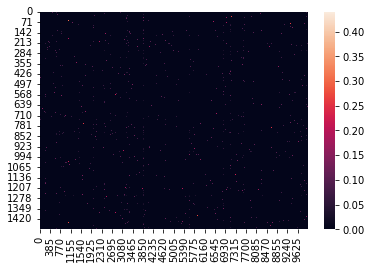

In [13]:
sns.heatmap(X_train.todense());


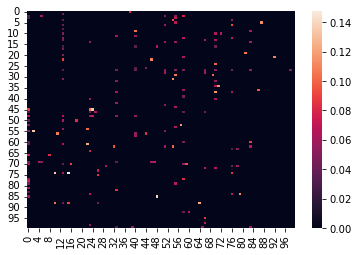

In [14]:
sns.heatmap(X_train.todense()[0:100,0:100]);

# Building and trainning the model.

I will calculate the Non-negative Matrix Factorization using NMF from sklearn decomposition. I will use 5 components as there are 5 different categories. And will use the train data to fit the model. 

In [15]:
from sklearn import decomposition
nmf_mod = decomposition.NMF(n_components=5,init='nndsvda')

W = nmf_mod.fit_transform(X_train)
H = nmf_mod.components_
nmf_mod.reconstruction_err_

37.3322584147751

The original matrix was factorized with a reconstruction error of 37.33 in two matrices W and H with sizes:

In [16]:
print(W.shape, H.shape)


(1490, 5) (5, 10000)


W has the five different topics per article and H has the words per topic. 
We apply the same matrix decomposition to the test data to be able to predict the categories of the test data. 

In [17]:
W_t = nmf_mod.transform(X_test)

### What are the most important words per topic.

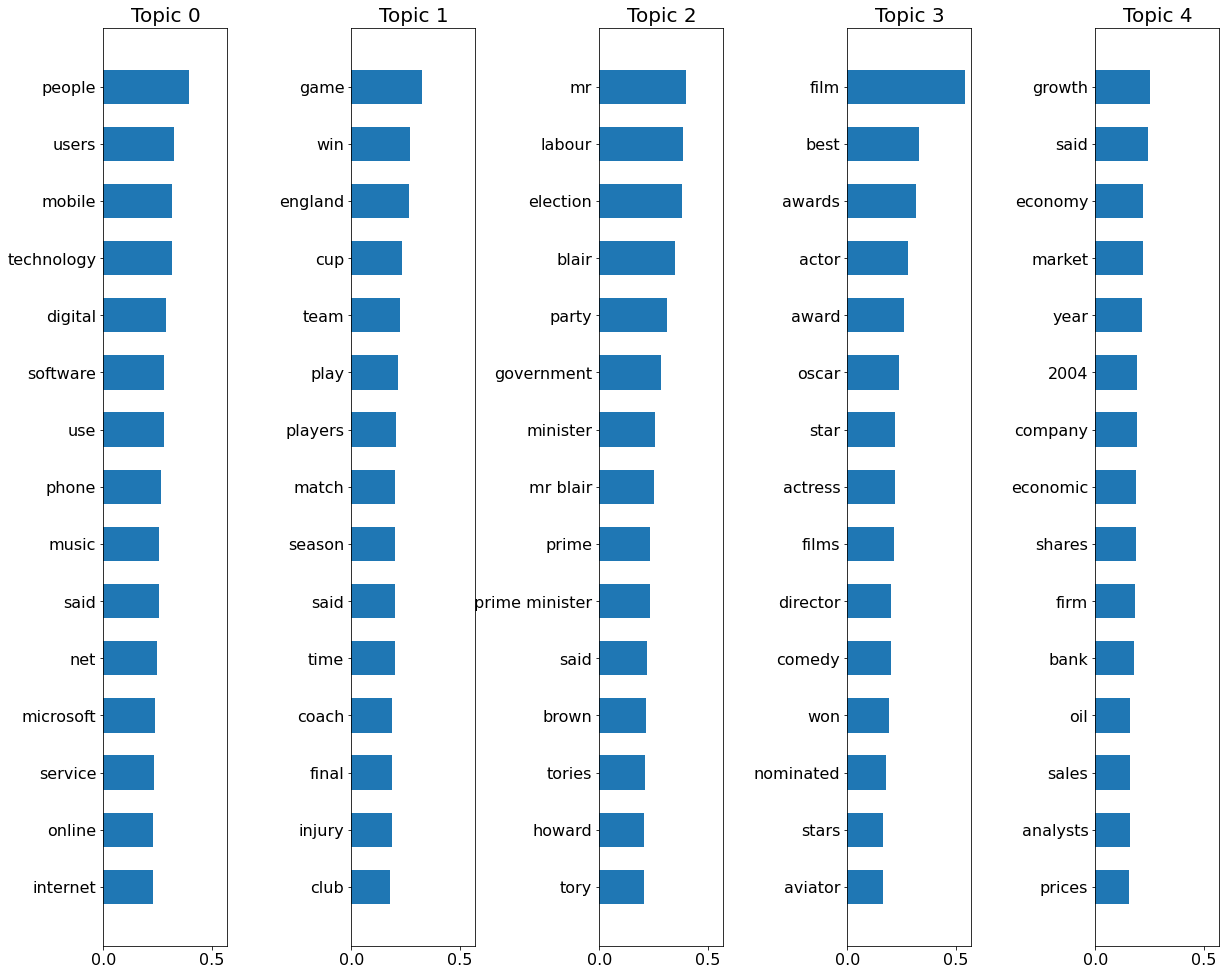

In [18]:
n_top = 16

fig, axes = plt.subplots(1, 5, figsize=(20, 15), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(nmf_mod.components_):
    top_features_ind = topic.argsort()[: -n_top : -1]
    top_features = [voc[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.6)
    ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 20})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=16)
    
plt.subplots_adjust(top=0.90, bottom=0.05, wspace=1)
plt.show()

From the most important words in each topic we can do the next mapping. 

|Topic Id|  Topic|
|:----|:--------:|
|0| Tech|
|1| Sport|
|2| Politics|
|3| Entertainment|
|4| Business|


And use it to see how well can the articles be divided according to its topics. 

In [19]:
L_names = DTrain.Category.unique()
id_top = np.array([4,0,2,1,3])
print(L_names)
print(id_top)
d_lab = dict(zip(L_names, id_top))
#Create list of labels with the current permutation tags. 
DTrain['topic_id'] = [d_lab[x] for x in DTrain.Category]


['business' 'tech' 'politics' 'sport' 'entertainment']
[4 0 2 1 3]


Get the topic of each article by finding which component each row in W is the predominant. To assign to which topic does each article belongs we find which column of the matrix W has the largest value. 

In [20]:
clusters = W.argmax(axis=1)
acc = accuracy_score(clusters,DTrain.topic_id)
print("The accuracy on the train data is:", round(acc,3))

The accuracy on the train data is: 0.946


And the confusion matrix for the train data is:


In [21]:
confusion_matrix(clusters,DTrain.topic_id)

array([[242,   0,   3,  13,   4],
       [  8, 341,   2,   6,   0],
       [  1,   1, 258,   3,   5],
       [  4,   2,   0, 242,   0],
       [  6,   2,  11,   9, 327]])

To find out the accuracy of the test data we also get the maximum colum per row in the W_t matrix and submit the results to kaggle by saving them in a CSV file.

In [22]:
R_test = DTest.drop(columns = {"Text"})
R_test['Category_id'] = W_t.argmax(axis=1)
r_lab = dict(zip(id_top,L_names))
#Create list of labels with the current permutation tags. 
R_test['Category'] = [r_lab[x] for x in R_test.Category_id]
R_test = R_test.drop(columns = {"Category_id"})

In [23]:
R_test.to_csv('BBC_test_pred.csv',index = False)

The kaggle score from the above results was 0.961


### Changing the hyperparameters. 
How does the results change if we use a different solver and loss function. The coordinate descend 'cd' solver only works with the frobenius loss, and the 'itakura-saito' loss doesn't work with sparse matrix as the one we got for our data.

To be able to compare results of train and test with the different hyperparameters and train and test data without having to submit to kaggle for each trial I will divide the train data in test and train. 

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, DTrain.topic_id,
                                                    test_size=0.2, random_state=42)




In [25]:
solver = ['cd','mu']
loss = ['frobenius', 'kullback-leibler']
Train_ACC = pd.DataFrame(columns = loss, index = solver)
Test_ACC = pd.DataFrame(columns = loss, index = solver)

for sl in solver:
    for l in loss:
        if (l != 'frobenius')&(sl=='cd'):
            pass
        else:
            nmf_mod = decomposition.NMF(n_components=5,solver= sl,beta_loss=l,init='nndsvda')
            W = nmf_mod.fit_transform(x_train)
            clusters = W.argmax(axis=1)
            Train_ACC.loc[sl,l] = round(accuracy_score(clusters,y_train),3)
            W_t = nmf_mod.transform(x_test)
            Test_ACC.loc[sl,l] = round(accuracy_score(W_t.argmax(axis=1),y_test),3)


print("Train Accuracy")
display(Train_ACC)
print("Test Accuracy")
display(Test_ACC)

Train Accuracy


,frobenius,kullback-leibler
cd,0.935,NaN
mu,0.938,0.961


Test Accuracy


,frobenius,kullback-leibler
cd,0.95,NaN
mu,0.96,0.977


We can see that the kullback-leibler loss function got a bit better results in both the train and test cases than frobenious. I tried seeing what happened adjusting the regularization parameter using using kullback_leibler but the results didn't change. However if we use the default 'cd' and frobenius.The other hyperparameter we can change and see how it reacts is the regularization. 

In [26]:
reg = [0,.25,0.5,1,2]
Accuracy = pd.DataFrame(columns = ['Train','Test'], index = reg)

for ir in reg:
    nmf_mod = decomposition.NMF(n_components=5, solver= 'cd',beta_loss='frobenius'
                                ,alpha =ir,init='nndsvda')
    W = nmf_mod.fit_transform(x_train)
    clusters = W.argmax(axis=1)
    Accuracy.Train[ir] = round(accuracy_score(clusters,y_train),3)
    W_t = nmf_mod.transform(x_test)
    Accuracy.Test[ir] = round(accuracy_score(W_t.argmax(axis=1),y_test),3)


Accuracy

,Train,Test
0.00,0.935,0.95
0.25,0.938,0.963
0.50,0.937,0.96
1.00,0.937,0.963
2.00,0.935,0.956


The accuracy increases slightly for small regularization parameters, but the results from kullback-leibler are better. This was expected as kullback+leiber works best with sparse matrices. So I will train the model using the kullback-leibler loss and the whole train data and submit the test results once again to kaggle to see if there was any improvements. 

In [27]:
nmf_mod = decomposition.NMF(n_components=5,init='nndsvda',
                            beta_loss='kullback-leibler',solver='mu')

W = nmf_mod.fit_transform(X_train)
W_t = nmf_mod.transform(X_test)

clusters = W.argmax(axis=1)
acc = accuracy_score(clusters,DTrain.topic_id)
print("The accuracy on the train data is:", round(acc,3))
R_test = DTest.drop(columns = {"Text"})
R_test['Category_id'] = W_t.argmax(axis=1)
r_lab = dict(zip(id_top,L_names))
#Create list of labels with the current permutation tags. 
R_test['Category'] = [r_lab[x] for x in R_test.Category_id]
R_test = R_test.drop(columns = {"Category_id"})
R_test.to_csv('BBC_test_pred.csv',index = False)

The accuracy on the train data is: 0.968


The train data accuracy increased, however when I submited the results to kaggle the test accuracy I got was  0.961, the same as with frobenius loss and cd solver. 

For feature extraction I tried using only the train texts and both the test and train texts. Using both the train accuracy slightly increased, but the test one stayed the same, so it doesnt seem like a real improvement. I tried different parameters when extracting the features, just doing the bag of words with out the inverse document training didnt get as good results as with the tf-idf. In tf-idf I also tried just using ngrams with 1 word or using also ngrams with 3 words, but the best result I got was with 1 and 2 words ngrams. 

# Compare with Supervised Learning. 
Before running a supervised clasification method on the data I will reduce the dimensions of the tf-idf matrix using Singular Value Decomposition. 

### Singular Value Decomposition. Truncated SVD.
I'm looking to have a variance ratio of at least 0.95

In [28]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components = 2000).fit(X_train)
cvar = np.cumsum(tsvd.explained_variance_ratio_)
N = np.where(cvar>0.95)[0][0]
tsvd = TruncatedSVD(n_components = N).fit(X_train)
x_tr = tsvd.transform(X_train)
x_ts = tsvd.transform(X_test)
print(N)

1171


### Random Forest
Given that there are still a lot of features 1171, and not that much data I will use a Random Forest classifier to classify the data. I will divide the train/test data with 30% of test data

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
x_train, x_test, y_train, y_test = train_test_split(x_tr, DTrain.Category,
                                                    test_size=0.3, random_state=42)

RF = RandomForestClassifier(n_estimators= 150,max_depth=3, random_state=30)
Rfm = RF.fit(x_train, y_train)

print("The train accuracy is: ",np.round(accuracy_score(Rfm.predict(x_train),y_train),3))
print("The test accuracy is: ",np.round(accuracy_score(Rfm.predict(x_test),y_test),3))


The train accuracy is:  0.953
The test accuracy is:  0.94


In [30]:
R_test.Category = Rfm.predict(x_ts)
R_test.to_csv("test_pred_RF.csv",index = False)

Using the previous classifier to predict the test cases and submiting to kaggle I got a 0.94013 accuracy. 


In [31]:
#Function that gets both the train and test accuracy for the 2 models
def model_comparison(test_fracc, modelns, models):
    #Divide the data sets.
    x_train, x_test, y_train, y_test = train_test_split(X_train, DTrain.topic_id,
                                                    test_size=test_fracc)
    #First get model ns.
    W = modelns.fit_transform(x_train)
    Acc_Train_ns = np.round(accuracy_score(W.argmax(axis=1),y_train),3)
    W_t = nmf_mod.transform(x_test)
    Acc_Test_ns = np.round(accuracy_score(W_t.argmax(axis=1),y_test),3)
    #Then model s.#First we fit it
    modelsf = models.fit(x_train, y_train)
    Acc_Train_RF = np.round(accuracy_score(modelsf.predict(x_train),y_train),3)
    Acc_Test_RF = np.round(accuracy_score(modelsf.predict(x_test),y_test),3)
    
    return Acc_Train_ns, Acc_Test_ns, Acc_Train_RF, Acc_Test_RF

To check how the two models behave with different train test data sets I will run the models and make a table with the average results. 

In [32]:
np.arange(0.1,1,0.05)

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [34]:
Mod_Acc = pd.DataFrame(columns = ['NMF_trial','NMF_test',
                                  'RF_trial','RF_test'],index=np.arange(0.1,1,0.05))

for test_fracc in Mod_Acc.index:
    acc = np.array([0,0,0,0])
    for trial in range(0,5):
        atr1,ats1,atr2,ats2 = model_comparison(test_fracc,nmf_mod,RF)
        acc = acc + np.array([atr1,ats1,atr2,ats2])
    acc = acc/5
    Mod_Acc.NMF_trial[test_fracc] = acc[0]
    Mod_Acc.NMF_test[test_fracc] = acc[1]
    Mod_Acc.RF_trial[test_fracc] = acc[2]
    Mod_Acc.RF_test[test_fracc] = acc[3]

Mod_Acc

,NMF_trial,NMF_test,RF_trial,RF_test
0.10,0.7752,0.7838,0.8672,0.8336
0.15,0.703,0.7242,0.8476,0.8062
0.20,0.6556,0.6576,0.8522,0.8254
0.25,0.6278,0.6218,0.8452,0.8054
0.30,0.7488,0.7534,0.8532,0.8236
0.35,0.6564,0.6554,0.8622,0.812
0.40,0.7466,0.7328,0.8658,0.8144
0.45,0.6082,0.6214,0.8812,0.827
0.50,0.5916,0.6014,0.8682,0.8094
0.55,0.4594,0.4702,0.8702,0.8266


We can see that the Random Forest perfoms better then the Non Negative Factorization when there are few data points for training the algorithm.  Other supervised algorithms might tend to overfit as the data has large number of features.


In [39]:
test_fracc = 0.1
acc = np.array([0,0,0,0])
for trial in range(0,10):
    atr1,ats1,atr2,ats2 = model_comparison(test_fracc,nmf_mod,RF)
    acc = acc + np.array([atr1,ats1,atr2,ats2])
acc/10

array([0.8533, 0.8557, 0.8612, 0.8403])

However in the case above where the test data is only the 10% we have a lot of data points to train and we get a more accurate test result in the matrix factorization than in the Random Forest.  

References.
https://en.wikipedia.org/wiki/Tf%E2%80%93idf

https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py